# High Harmonic Generation in Gas Targets
To understand how the high harmonic generation (HHG) process occurs one can refer to the ''three-step model'' given by Corkum, P. B. et al., Phys. Rev. Lett., 71(13), 1994. 

The HHG process (see image taken from [wikipedia](https://en.wikipedia.org/wiki/High_harmonic_generation)):
1. The driving laser pulse bends the atomic potential allowing the electron to undergo tunnel ionization
2. Free electron accelerated by the driving laser pulse
3. Recombination of electron with the core as the oscillating electric field changes its sign. The electron acquires kinetic energy during the acceleration phase is emitted. Hence, the emitted radiation might higher frequency. 

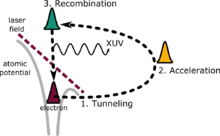

In [3]:
from IPython.display import Image
import os
_pwd = os.getcwd()
Image(os.path.join(_pwd, "images", "3stepmodel.png"))
# \url{https://commons.wikimedia.org/wiki/File:ThreeStep.png}

The kinetic energy acquired by the electron due to acceration by the driving pulse depends on the strength of the driving field. 
Hence, the cutoff frequency ($\omega_c$) that can be released on recombination is given as: $\hbar~\omega_c \approx 3.17U_p + I_p$. $U_p$ is the pondermotive energy of the electron depending on the Intensity (I) and frequency ($\omega_0$) of the driving laser pulse,  and the ionization potential of the atom ($I_p$), $U_p = 2e^2/(c\epsilon_0m)\times I/(4\omega^2_0)$

A simple quantum-mechanical description for the HHG can be given by the three-dimensional time-dependent Schrödinger equation
(TDSE) for one shell electron:
$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$i\frac{\partial}{\partial~t}\ket{\Psi(t)} = [-\frac{1}{2}\nabla^2 + V(r) - Ecos(t)x]\ket{\Psi(t)}$$
$V(r)$: Atomic potential

$Ecos(t)x$: Electric field potential

From the solution of above equation, one can calculate the non-linear dipole response D(t) using the dipole operator $\hat{D}$:
$$D(t) = \bra{\Psi(t)}\hat{D}\ket{\Psi(t)}$$
$$D(t)\approx -j \int_{t_0}^{t}dt^\prime \int dp e^{-j\int_{t^\prime}^{t}d\tau[\frac{[p+A(\tau)]^2}{2}]+I_p}$$
For a single atom case, $\hat{D}=-\hat{r}$ and $t_0\rightarrow-\infty$

Lewenstein Integral:

$$D(t)\approx j\int_{-\infty}^{t}dt^\prime \int dp \underbrace{e^{-jI_pt}d^*[p+A(t)]}_{Recombination} \times \underbrace{e^{-jS_{GV}(p,t,t^\prime)}}_{Propagation}\times \underbrace{e^{jI_pt^\prime F(t^\prime)d[p+A(t^\prime)]}}_{Ionization}+c.c.$$

Dipole matrix elements: $d[p+A(t^\prime)] = \bra{p+A(t^\prime)}\hat{r}\ket{g}$ and $d^*[p+A(t^\prime)]$

Vector potentials: $A(t^\prime)$ and $A(t)$

# Python code for the single-atom dipole response

Typical HHG spectra of HHG in gas will have three regions:
1. Perturbative Regime
2. Plateau
3. Cutoff

We will use the lewenstein model (implemented in [HHGMax code](https://mhoegner.gitlab.io/hhgmax-homepage/)) for the single-atom dipole response. A clone of the HHGMax code is attached to this notebook.

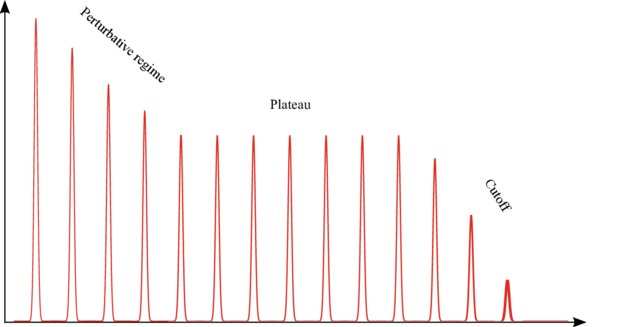

In [5]:
Image(os.path.join(_pwd,"images", "HHG_3regions.png"))

Electric field parameters:

$\lambda = 800\textrm{nm}$

FWHM = $30\times 10^{-15}\textrm{s= 30\textrm{fs}}$

Ionization Potentials:

He = 24.5874eV

Ne = 21.5645eV

Ar = 15.7596eV

Kr = 13.9996eV

Xe = 12.1298eV

Peak Intensity = $1\times 10^{14} \frac{\textrm{TW}}{\textrm{cm}^2}$

In [1]:
import os, sys
import numpy as np
from scipy.constants import elementary_charge, speed_of_light, pi, femto, nano, tera, epsilon_0
from hhgmax import pylewenstein

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 120   # make figures larger

The following cell will prompt for the simulation parameters. Give these according to the reference values above.

In [3]:
# set pulse parameters (everything is SI units)
wavelength = float(input("Wavelength in nm (800): "))*nano # 1000 nm
fwhm = float(input("FWHM in fs, 30: "))*femto # 30 fs
peak_intensity = float(input("Intensity in TW/cm2 (1TW = 1e12W) (100): "))*tera * 1e4 # 1e14 W/cm^2

# set system parameters
n = int(input("Number of simulated elements, (3): "))
name_of_atoms = list(map(str,input("Symbols of the simulated elements (He Ne Ar): ").strip().split()))[:n]
ionization_potential = list(map(float,input("Ionization potential(s) in eV (24.5874 21.5645 15.7596): ").strip().split()))[:n] # 12.13 eV (Xe)

In [4]:
# define time axis
T = wavelength/speed_of_light # one period of carrier
t = np.linspace(-30.*T,30.*T,200*40+1)

# define electric field: Gaussian with given peak intensity, FWHM and a cos carrier
tau = fwhm/2./np.sqrt(np.log(np.sqrt(2)))

In [5]:
# construct Electric field of a Gaussian pulse in time domain
def Gauss_pulse(_t, _T,_tau, _I):
    _Et = np.exp(-(_t/_tau)**2) * np.cos(2*pi/_T*_t) * np.sqrt(2*_I/speed_of_light/epsilon_0)
    return _Et

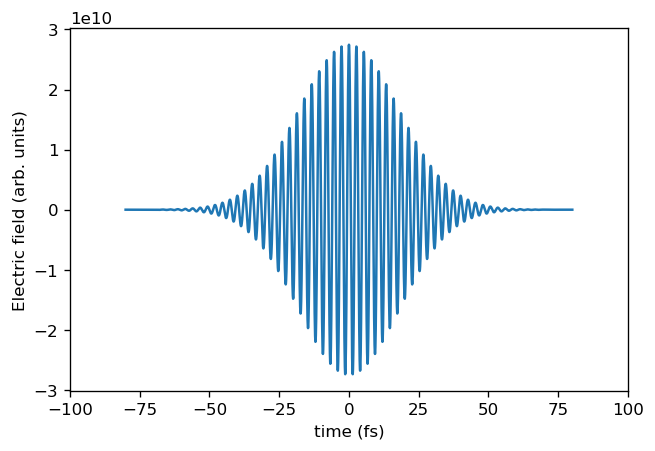

In [8]:
# plotting the gaussian electric field
Et = Gauss_pulse(t, T, tau, peak_intensity)
plt.plot(t/femto, Et)
plt.xlim([-100, 100])
plt.xlabel('time (fs)')
plt.ylabel('Electric field (arb. units)')
plt.show()

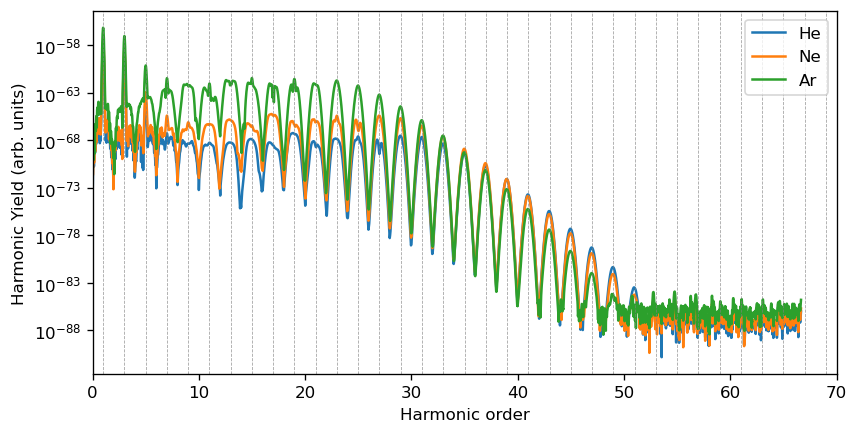

In [14]:

# use module to calculate dipole response (returns dipole moment in SI units)
plt.figure(figsize=(8,4))
for ii, iv in enumerate(ionization_potential):
    d = pylewenstein.lewenstein(t,Et,iv*elementary_charge,wavelength)
    q = np.fft.fftfreq(len(t), t[1]-t[0])/(1./T)
    plt.semilogy(q[q>=0], abs(np.fft.fft(d)[q>=0])**2, label=name_of_atoms[ii])
# plot lines at odd harm. orders 
for i in range(35):
    plt.axvline(1+2*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)
plt.xlim((0,70))
plt.xlabel('Harmonic order')
plt.ylabel('Harmonic Yield (arb. units)')
plt.legend(loc='upper right')
plt.show()